## Assignment 3 Question 2

Is it possible to predict ELO of a player based on context of a potential en passant move?

Only investigating the player who is in the position of making the en passant move.

Lila See FDS PCA solutions for 3 good points for what PCA is good for - include in report?

#### Import Libraries

In [49]:
import pandas as pd
import chess
import chess.pgn
import chess.engine
import io
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import importlib
import math

from pandarallel import pandarallel

import data_cleaning

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from matplotlib.colors import ListedColormap

#### Import stockfish 🐟🐟🐟

In [50]:
# Windows installation
# STOCKFISH_LOC = os.getcwd() + "\stockfish\stockfish-windows-2022-x86-64-avx2.exe"
STOCKFISH_LOC = os.getcwd() + "\stockfish_14_win_x64\stockfish_14_x64.exe"
# Unix based installation i.e. DICE/Codespaces
STOCKFISH_LOC_UNIX = os.getcwd() + "/stockfish_14_linux/stockfish_14_x64"

# Import stockfish package
from stockfish import Stockfish
# Try and read windows location
try:
    fish = Stockfish(path=STOCKFISH_LOC, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# If error, read the linux location
except:
    fish = Stockfish(path=STOCKFISH_LOC_UNIX, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# It will throw an error but if it still runs then ignore it :D

#### Import CSV file

66879 entries in dataframe

In [51]:
chess_data = data_cleaning.import_data()
print(chess_data.dtypes)

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object


#### Dataframe info

Using:
print(chess_data.dtypes)
print(chess["rules"].unique())


Chess rules:
['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']

Time control:
['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
 '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
 '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
 '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
 '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
 '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
 '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
 '60+10']

 Time class:
['daily' 'rapid' 'bullet' 'blitz']

#### Clean data

Undeveloped board shouldn't matter if we're filtering games for potential ep

Same for draws

Can filter our time class if are looking at time controls

After making a new move_list column, should we drop the pgn column?


Variables we are considering when predicting ELO (for a player who could potentially make en passant move) are:
- Colour who had ep opportunity (boolean)
- Did they take the en passant? (boolean)
- Does their choice on taking/not taking support them if gaining an advantage? (numerical value for how much of an advantage it gives) [Lila rn is __________________]
- 
- Time taken to decide to capture/not capture en passant (percentage of total time for the game)
- Is the game rated? (boolean)
- Game time class (numerical value), don't include daily because daily don't have times attached to move

In [52]:
# Save PGN column from dataframe
full_pgn = chess_data['pgn']

def get_moves(entry):
    '''
    Retrive series of moves in a game when given the whole full_pgn entry.
    '''
    pgn = entry.splitlines()[-1]
    return pgn

# Add list of moves (string) as a new column to dataframe
chess_data['move_list'] = full_pgn.apply(get_moves)

# Drop irrelevant columns
chess_data = chess_data.drop(['white_id', 'black_id', 'white_result', 'black_result', 'rules'], axis=1)

### Processing data and adding information

#### Checks every game for ones that have potential en-passant moves
- Gets whether a game has an en-passant opportunity
- Gets whether the said en passant move was played
- Gets the colour of the player that has the e.p. opportunity

In [53]:
def check_pgn(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False
    moved = False
    move_colour = ""

    # comparison sets when checking move piece
    ep_set = set(["ax","bx","cx","dx","ex","fx","gx", "hx"])
    check_set = set("abcdefgh")
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        move = board_move.move
        san = board.san(move)
        turn = board.turn
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # print(board_move.clock())
            # get first 2 letters, and compare to a set
            move_ep_piece = san[:2]
            if move_ep_piece in ep_set:
                # check if e.p. actually happened
                moved = board.is_en_passant(move)
            # break out for loop, no need to check further
            break
        
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # if precheck is true then set the turn
            if precheck:
                if turn:
                    move_colour = 'Black'
                else:
                    move_colour = 'White'
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    
    # set row values
    df_row["ep_opportunity"] = precheck
    df_row["ep_happened"] = moved
    df_row["ep_colour"] = move_colour
    return df_row

chess_filter = chess_data.copy(deep=True)
# chess_filter = chess_data[chess_data["time_class"] != "daily"].sample(100).copy(deep=True)
pandarallel.initialize()

start = time.time()
# apply e.p. finding function
try:
    chess_filter = chess_filter.parallel_apply(check_pgn, axis=1)
except:
    chess_filter = chess_filter.apply(check_pgn, axis=1)
end = time.time()
print(end - start)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
97.89344954490662


#### Filter out games that don't have en-passant opportunity

In [54]:
chess_filter = chess_filter[chess_filter['ep_opportunity'] == True]
chess_filter = chess_filter.drop(['ep_opportunity'], axis=1)
chess_filter = chess_filter.reset_index(drop=True)
print(len(chess_filter))
print(len(chess_filter[chess_filter['ep_happened'] == True]))
# print(chess_filter["move_list"].sample(50).head(20))

5074
1563


#### Get the time taken to respond to an en-passant pawn move

In [55]:

def check_times(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    # print(df_row["move_list"])
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False

    # comparison sets when checking move piece
    check_set = set("abcdefgh")
    
    rolling_white_time = [0,0]
    rolling_black_time = [0,0]
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        # print(board_move.clock())
        if board.turn:
            rolling_white_time = [board_move.clock(), rolling_white_time[0]]
            # print(rolling_white_time)
        else:
            rolling_black_time = [board_move.clock(), rolling_black_time[0]]
            # print(rolling_black_time)
        
        move = board_move.move
        san = board.san(move)
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # print(board_move.clock())
            # get first 2 letters, and compare to a set
            norm = df_row["time_control"]

            if board.turn:
                df_row["time_taken"] = (rolling_white_time[1] - rolling_white_time[0])/float(norm)
            else:
                df_row["time_taken"] = (rolling_black_time[1] - rolling_black_time[0])/float(norm)
            # print(df_row)
            return df_row
        
        # if the move was a pawn (lower case)
        # print(move_piece)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # print(precheck)
            # if precheck is true then set the turn
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    return df_row

# parallel processing
pandarallel.initialize()

start = time.time()

# if device supports parallel processing then apply, else use regular apply
try:
    chess_filter = chess_filter.parallel_apply(check_times, axis=1)
except:
    chess_filter = chess_filter.apply(check_times, axis=1)
end = time.time()
print(end - start)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
7.583624839782715


#### Stockfish Evaluation to get evaluations of board choices
- Gets the evaluation before an ep opportunity
- Gets the evaluation of the best move calculated by Stockfish
- Gets the evaluation of the (best) en passant move calculated by Stockfish

In [56]:
import stockfish_eval
importlib.reload(stockfish_eval);

def stockfish_analyse_board(df_row, board, move):
    '''
    Gets a stockfish evaluation of the best move played, if e.p. is played,
    and the stockfish evaluation of the player's move
    
    Returns the pre-move evaluation, evaluation of best move, evaluation
    of (best) en passant move, evaluation of players move. evals are an absolute
    value so the same for both sides, and calculated as the difference from the pre-move

    '''
    
    # initialise stockfish
    fish_eval = stockfish_eval.StockfishEval(fish, board, df_row["ep_colour"])

    # reset fen to board position
    fish_eval.reset_fen()
    
    # set the player move class variable
    fish_eval.set_player_move(move)
    # get pre-move stockfish evaluation of board
    pre_eval = fish_eval.evaluate_board()["value"]
    
    # get the best move and store in class variable
    fish_eval.find_best_move()
    
    # find adjacent squares to pawn move
    fish_eval.find_adj_squares()
    # find if square is on a left bound (A file) or right bound (H file)
    fish_eval.find_bounds()
    # find if each valid square is also a valid (opposing) pawn
    fish_eval.find_valid_pawns()

    # find a fen representation of each move
    fish_eval.find_ep_moves()
        
    
    move_list = fish_eval.get_movelist()
    # should end up with move_list class variable in the following configs
    
    # | best_move | player_move | ep_move_left | ep_move_right|
    # |===========|=============|==============|==============|
    # |   move    |    move     |     move     |     move     |
    # |   move    |    move     |     ----     |     move     |
    # |   move    |    move     |     move     |     ----     |
    
    # get the evaluation of the best move, and absolute advantage
    best_eval = fish_eval.evaluate_move(move_list["best_move"])
    best_difference = fish_eval.get_abs_advantage(best_eval, pre_eval)
    
    
    # lookup table of en-passant moves
    ep_moves = [move_list["ep_move_left"], move_list["ep_move_right"]]
    # if the best move is also an en-passant
    
    if move_list["best_move"] in ep_moves:
        # set the ep_eval to best val. This is for consistency because
        # stockfish returns a different evaluation each time you run a move
        
        ep_eval = best_eval
        ep_difference = best_difference
    else:
        # if it's different, then evaluate e.p. move separately
        # evaluate_en_passants() finds evaluation for both moves,
        # and returns the maximum value i.e. the better e.p. move
        ep_eval = fish_eval.evaluate_en_passants()
        ep_difference = fish_eval.get_abs_advantage(ep_eval, pre_eval)
    
    
    # if the player move is the best move
    if fish_eval.get_movelist()["best_move"] == move:
        # same thing as en-passant
        best_eval = best_eval
        player_difference = best_difference
    else:
        player_eval = fish_eval.evaluate_move(move_list["player_move"])
        player_difference = fish_eval.get_abs_advantage(player_eval, pre_eval)
    
    return [pre_eval, best_difference, ep_difference, player_difference]

def get_advantage(df_row):
    '''
    Get stockfish evaluations for a given game. For a dataframe row,
    sets columns "pre_state", "state_best", "state_ep", "state_player"
    '''
    
    # pawn lookup set
    check_set = set("abcdefgh")
    # print(df_row.name)
    
    # initialise board
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game

    # e.p. check
    precheck = False
    
    # initialise vars
    pre_eval = 0
    best_eval = 0
    ep_eval = 0
    player_eval = 0
    
    # iterate over every move in a game
    for move in game.mainline_moves():
        # representation of a move
        san = board.san(move)
        move_piece = san[0]

        # check if precheck was flagged in previous move
        if precheck:
            # reset to not flag final move precheck edge case 
            precheck = False

            # analyse board
            values = stockfish_analyse_board(df_row, board, str(move))
            # print(values)
            # set values
            pre_eval = values[0]
            best_eval = values[1]
            ep_eval = values[2]
            player_eval = values[3]
            # break out of for loop since we have all values
            break
            
            
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)

    # edge case where the final move was pawn 2 space, and there is no next
    # move to run stockfish_analyse_board. In this case just return NA
    # since there was no best move to compare to if the game has ended
    if precheck:
        pre_eval = pd.NA
        best_eval = pd.NA
        ep_eval = pd.NA
        player_eval = pd.NA
    
    # set dataframe values
    df_row["pre_state"] = pre_eval     # pre-moved stockfish eval
    df_row["state_best"] = best_eval  # stockfish eval if best move
    df_row["state_ep"] = ep_eval
    df_row["state_player"] = player_eval
    # print(df_row["pgn"])
    return df_row

print(len(chess_filter))
# get_advantage(chess_filter.iloc[486])
chess_filter = chess_filter.apply(get_advantage, axis=1)

5074


In [57]:
# the only player that matters is the one with e.p. opportunity
# so discard the rest

def get_player_stats(df_row):
    '''
    returns the player with e.p. opportunity's ELO and username.
    Also deletes the hanging username/rating fields for both sides.
    '''
    
    try:
        a = df_row["white_rating"]
    except:
        return df_row
    
    # binary check
    col = df_row["ep_colour"]
    if col == "White":
        elo = df_row["white_rating"]
        user = df_row["white_username"]
    else:
        elo = df_row["black_rating"]
        user = df_row["black_username"]
    
    # set new fields
    df_row["player_rating"] = elo
    df_row["username"] = user
    
    # drop fields
    df_row = df_row.drop(["white_username", "black_username"])
    df_row = df_row.drop(["white_rating", "black_rating"])
    return df_row

chess_filter = chess_filter.apply(get_player_stats, axis=1)

print(chess_filter.head(1))

  ep_colour  ep_happened                                                fen  \
0     White        False  r4k2/1p3r2/p2p2n1/2pPp3/2P1P1b1/1P2b1P1/P3NR1P...   

                                           move_list  \
0  1. d4 {[%clk 0:10:00]} 1... c5 {[%clk 0:09:58....   

                                                 pgn  rated time_class  \
0  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...   True      rapid   

  time_control  time_taken pre_state state_best state_ep state_player  \
0          600    0.013667       278        -12     -105          -12   

   player_rating username  
0           1498   -basu-  


### Applying PCA


#### Normal distribution of player ELO

standard deviation: 399.373996237217
mean: 1240.5744974379188


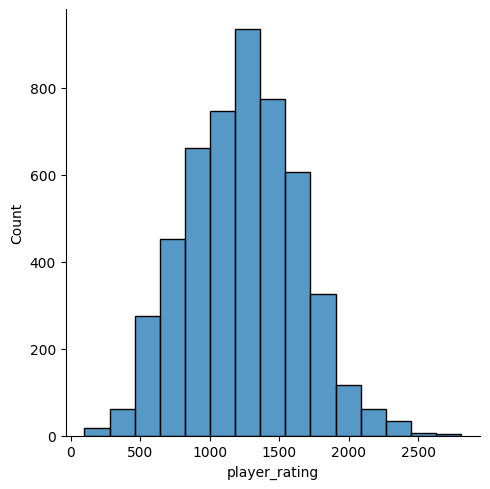

In [58]:
# get mean and std
mean = chess_filter["player_rating"].mean()
std = chess_filter["player_rating"].std()

# display normal distribution
fhgt_hist = sns.displot(chess_filter["player_rating"], kde = False, bins = 15)

print("standard deviation: " + str(std))
print("mean: " + str(mean))

In [228]:
def group_elo_tens(df_row):
    '''Rounds a player's ELO to the nearest 10 and create a new field for it'''    
    
    df_row["elo_class_tens"] = int(math.ceil(df_row["player_rating"] / 10.0)) * 10
    return df_row

def divider(df_row):
    '''Divides the amount of times en passant happened in an ELO class by
    the total number of en passant opportunities'''
    
    df_row["quotient"] = df_row["instances"] / df_row["total"]
    return df_row

def apply_quotient(df_row):
    '''For each row, store the probability of someone in
    their rounded elo class playing en-passant'''
    
    num = df_row["elo_class_tens"]
    
    # get probability from separate grouped dataframe
    quot = temptation_quotient.loc[num]["quotient"]
    df_row["quotient"] = quot
    return df_row

def temptation(df_row):
    '''For a board state, get the en-passant temptation of said state'''
    
    # arbritrary constant
    const = 220
    temptation = -1*(np.exp((df_row["state_best"] - df_row["state_ep"])/const))+1
    
    # if division by zero just exclude
    if (df_row["state_best"] == 0):
        df_row["temptation"] = pd.NA
    else:
        df_row["temptation"] = temptation
    return df_row

def group_temptation(df_row):
    temp_val = df_row["temptation"]

    vals = [-0.25, -0.5, -1, -2, -4, -8, -16, 10]
    
    for val in vals:
        if temp_val > val:
            df_row["tempt_group"] = val
            break
        else:
            df_row["tempt_group"] = 10
    
    # power = -2
    # while temp_val < -1*(2**(power)):
    #     power += 1
    # df_row["tempt_group"] = 2**power
    # print(2**power)
    return df_row

def group_elo_stds(df_row):
    '''Group a player's ELO in larger ELO class for PCA and KNN predictions'''
    
    elo = df_row["player_rating"]
    if elo <= 1000: # approx (mean - std)
        df_row["elo_class"] = 1 # "Low ELO: 0 - ~1000"
    elif elo <= 1400: # approx (mean + std)
        df_row["elo_class"] = 2 # "Average ELO: ~1000 - ~1400"
    else:
        df_row["elo_class"] = 3 # "High ELO: ~1400+"
    return df_row

def get_quotients(dataframe):
    unique_tempts = pd.unique(dataframe["tempt_group"])
    unique_elos = pd.unique(dataframe["elo_class_tens"])

    df_array = []
    pd.options.mode.chained_assignment = None
    for tempt in unique_tempts:
        for elo in unique_elos:
            sum_df = dataframe[(dataframe["tempt_group"] == tempt) & (dataframe["elo_class_tens"] == elo)]
            num_ep_happened = len(sum_df[sum_df["ep_happened"] == True])
            num_total = len(sum_df)
            if num_total == 0:
                continue
            else:
                sum_df.loc[:, "quotient"] = num_ep_happened / num_total
            # print("number of ep: " + str(num_ep_happened))
            # print("number of total: " + str(num_total))
            # print("ELO: " + )
            df_array.append(sum_df)
    
    return pd.concat(df_array)

# copy chess filter
temptation_data = chess_filter.copy(deep=True)

# Group data by 10s
temptation_data = temptation_data.apply(group_elo_tens, axis=1)
temptation_data = temptation_data.dropna()

# get a temptation score for each game
temptation_data = temptation_data.apply(temptation, axis=1)
temptation_data = temptation_data.dropna()

# group temptation in 
temptation_data = temptation_data.apply(group_temptation, axis=1)
temptation_data = get_quotients(temptation_data)
temptation_data = temptation_data.dropna()

# main elo class grouping
temptation_data = temptation_data.apply(group_elo_stds, axis=1)

# filter out any entries with negative time taken (for some reason there are some)
temptation_data = temptation_data[temptation_data["time_taken"] > 0]

# filter out crazy high temptations
temptation_data = temptation_data[temptation_data["temptation"] > -500]
temptation_data = temptation_data[temptation_data["temptation"] <= 500]
temptation_data = temptation_data[temptation_data["temptation"] < 0]

# Save for later function tempting(n)
save_temptation_data = temptation_data.copy(deep=True)

# temptation_data = make_temptation_dataframe()
temp_clone = temptation_data.copy(deep=True)

In [206]:
print(len(save_temptation_data[save_temptation_data["elo_class"] == 1]))
print(len(save_temptation_data[save_temptation_data["elo_class"] == 2]))
print(len(save_temptation_data[save_temptation_data["elo_class"] == 3]))

748
907
848


In [215]:
# display normal distribution
# plot = sns.displot(temptation_data["temptation"], kde = False, bins = 50)
print(len(temptation_data[(temptation_data["temptation"] > -0.25)]))
print(len(temptation_data[(temptation_data["temptation"] > -0.5)]))
print(len(temptation_data[(temptation_data["temptation"] > -1)]))
print(len(temptation_data[(temptation_data["temptation"] > -1.5)]))
# plot.set(xlim=(-100, 0))

401
766
1297
1593


#### Reason for ELO grouping to classify probability

ELO grouping
standard deviation: 17.943348185429155
mean: 22.352422907488986

username grouping
standard deviation: 4.036735195470186
mean: 1.7370763437179049


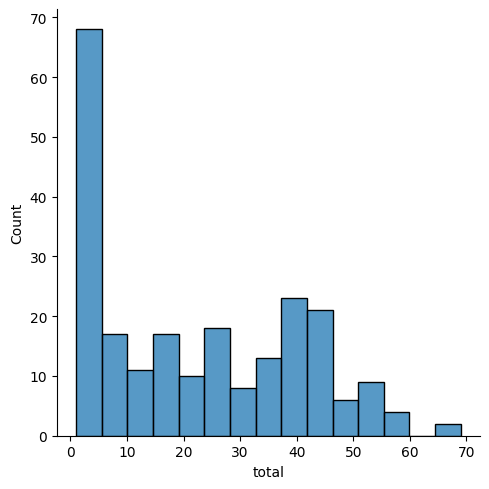

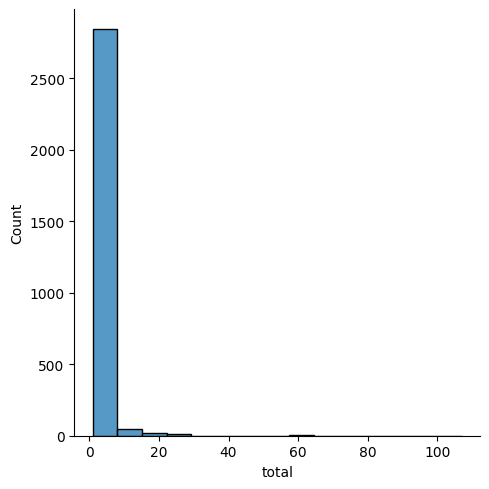

In [61]:
# mini clone of make_temptation_dataframe()
temptation_data_2 = chess_filter.copy(deep=True)

# Group data by 10s
temptation_data_2 = temptation_data_2.apply(group_elo_tens, axis=1)

# total amount of a group has a potential e.p. move
temptation_totals = temptation_data_2.groupby('elo_class_tens').size().rename("total")
# amount of times a group actually made the e.p. move
temptation_instances = temptation_data_2.groupby('elo_class_tens')['ep_happened'].sum().rename("instances")

# data for groups of 10
mean = temptation_totals.mean()
std = temptation_totals.std()
fhgt_hist = sns.displot(temptation_totals, kde = False, bins = 15)
print("ELO grouping")
print("standard deviation: " + str(std))
print("mean: " + str(mean))
print()

# data for groups of username
username_totals = temptation_data_2.groupby('username').size().rename("total")

mean = username_totals.mean()
std = username_totals.std()

fhgt_hist = sns.displot(username_totals, kde = False, bins = 15)

print("username grouping")
print("standard deviation: " + str(std))
print("mean: " + str(mean))

#### Graph of temptation against probability

(-50.0, 0.0)

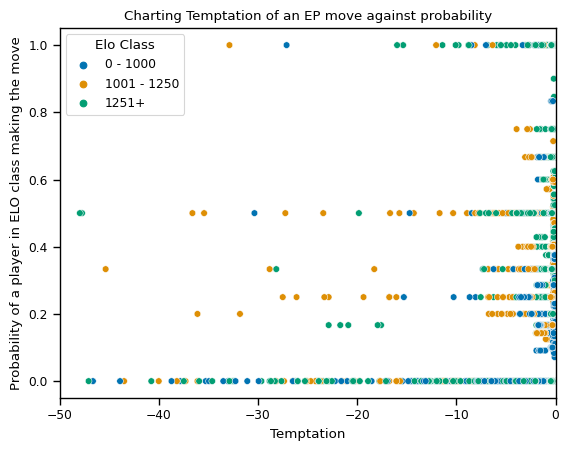

In [231]:
elo_class_display = temptation_data["elo_class"].replace({
    1: "0 - 1000",
    2: "1001 - 1250",
    3: "1251+"
})

# print(temptation_data[temptation_data["temptation"] < -400].head())
# print(len(temptation_data[temptation_data["temptation"] < -400]))

ax1 = sns.scatterplot(x=temptation_data["temptation"], y=temptation_data["quotient"], 
                hue=elo_class_display, palette="colorblind", hue_order=['0 - 1000', '1001 - 1250', '1251+'])
sns.move_legend(ax1, title='Elo Class', loc='best')
ax1.set_xlabel('Temptation')
ax1.set_ylabel('Probability of a player in ELO class making the move')
ax1.set_title('Charting Temptation of an EP move against probability')
ax1.set_xlim((-100, 0))

In [212]:
print(temptation_data[temptation_data["temptation"] < -400].head())

      ep_happened  time_class  time_taken  state_player  elo_class_tens  \
32              0           2    0.033833           -53            1410   
4068            0           0    0.016667          -163            1220   
964             0           1    0.008333           -94            1310   
1448            1           0    0.005833         -1482             500   
3778            0           1    0.012222           -24            2060   

      temptation  tempt_group  quotient  elo_class  
32   -478.492030         0.25  0.416667          3  
4068 -489.514355         0.25  0.440000          2  
964  -465.591688         0.25  0.194444          2  
1448 -411.702615         0.25  0.125000          1  
3778 -428.936001         0.25  0.000000          3  


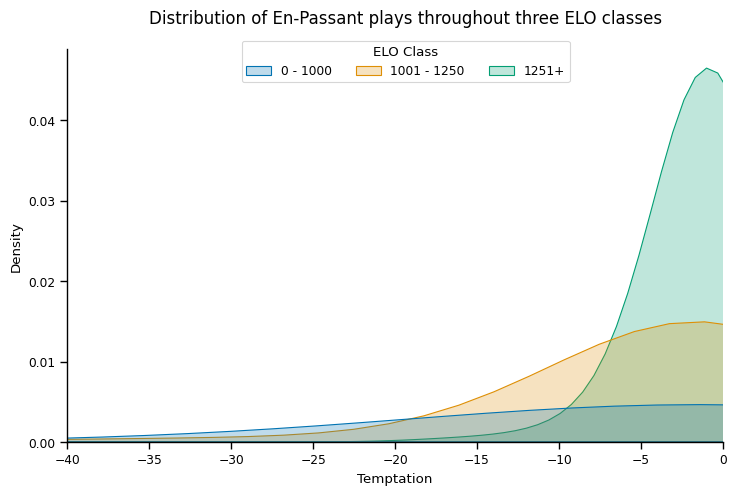

In [166]:
only_ep = temptation_data[temptation_data["ep_happened"] == True]

grouped_class = pd.DataFrame(data=np.c_[only_ep["temptation"], only_ep["elo_class"]],
                             columns=["temptation", "elo_class"])

ax2 = sns.displot(data=grouped_class, x='temptation', hue='elo_class', kind="kde", 
                  fill=True, palette="colorblind", height=5, aspect=1.5)
ax2.set(xlim=(-40, 0), xlabel="Temptation")
ax2.fig.suptitle("Distribution of En-Passant plays throughout three ELO classes", fontsize=12)
ax2.fig.subplots_adjust(top=0.9)
# ax2.set_title("test")
sns.move_legend(ax2, "upper center", ncol=3, title="ELO Class", bbox_to_anchor=(0.5, 0.93)
                , frameon=True)

new_labels = ['0 - 1000', '1001 - 1250', '1251+']
for t, l in zip(ax2._legend.texts, new_labels):
    t.set_text(l)

sns.set_context("paper")

#### Prepare unneccessary columns and set dummy variables for PCA 

In [209]:
def prep_temptation_dataframe(temptation_data):
    # Uneccessary columns for PCA
    temptation_data = temp_clone.drop(['fen', 'pgn', 'move_list', 'time_control', 'player_rating'], axis=1)
    temptation_data = temptation_data.drop(['state_best', 'state_ep', 'pre_state', 'username'], axis=1)

    # Dummy variables
    temptation_data['ep_happened'] = temptation_data['ep_happened'].replace({True:1, False:0})
    temptation_data['ep_colour'] = temptation_data['ep_colour'].replace({'White':1, 'Black':0})
    temptation_data['rated'] = temptation_data['rated'].replace({True:1, False:0})
    temptation_data['time_class'] = temptation_data['time_class'].replace({'rapid':2, 'blitz':1, 'bullet':0})

    # Drop columns that don't contribute to PCA
    temptation_data = temptation_data.drop(['rated', 'ep_colour'], axis=1)
    return temptation_data

temptation_data = prep_temptation_dataframe(temptation_data)
print(temptation_data.dtypes) # PCA hyperparameters

ep_happened         int64
time_class          int64
time_taken        float64
state_player        int64
elo_class_tens      int64
temptation        float64
tempt_group       float64
quotient          float64
elo_class           int64
dtype: object


#### Testing coefficients for exponential model

In [145]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

def tempting(n):
    
    temptation_data = save_temptation_data.copy(deep=True)
    temptation_data = prep_temptation_dataframe(temptation_data)
    
    elo_labels=temptation_data["elo_class"]
    elo_features=temptation_data.drop(columns=["elo_class"])

    train, test, train_lbl, test_lbl = train_test_split(elo_features, elo_labels, test_size=0.2)

    scaler = StandardScaler()
    scaler.fit(train)

    # Apply transform to both the training set and the test set
    train = scaler.transform(train)
    test = scaler.transform(test)
    # Make an instance of the pca model
    pca = PCA(n_components=(len(temptation_data.columns)-1))
    pca.fit(train)
    # print(pca.explained_variance_ratio_)

    # Transform images with pca model
    train_result = pca.transform(train)
    test_result = pca.transform(test)
    # print(train_result)
    # Make an instance of knn model

    # get the highest accuracy number of neighbours
    kns = 0
    n_neighbors = 0
    for i in range (3,7):
        knn = KNeighborsClassifier(i)
        knn.fit(train_result, train_lbl)

        # Accuracy of knn test
        if knn.score(test, test_lbl) > kns:
            kns = knn.score(test, test_lbl)
            n_neighbors = i

    accuracy = 0
    for i in range(100):
        # print("optimal num: " + str(n_neighbors))
        knn = KNeighborsClassifier(n_neighbors)
        knn.fit(train_result, train_lbl)
        accuracy += knn.score(test, test_lbl)
    print(str(n) + " factor: " + str(accuracy/100))
    
    return accuracy/100

for i in range(1):
    tempting(220)

220 factor: 0.5129740518962079


In [210]:
elo_labels=temptation_data["elo_class"]
elo_features=temptation_data.drop(columns=["elo_class"])

train, test, train_lbl, test_lbl = train_test_split(elo_features, elo_labels, stratify=elo_labels, test_size=0.4)

scaler = StandardScaler()
scaler.fit(train)

# Apply transform to both the training set and the test set
train = scaler.transform(train)
test = scaler.transform(test)

# Make an instance of the pca model
pca = PCA(n_components=(len(temptation_data.columns)-1))
pca.fit(train)
print(pca.explained_variance_ratio_)

# Transform images with pca model
train_result = pca.transform(train)
test_result = pca.transform(test)
# print(train_result)
# Make an instance of knn model

# get the highest accuracy number of neighbours
kns = 0
n_neighbors = 0
for i in range (3,7):
    knn = KNeighborsClassifier(i)
    knn.fit(train_result[:,:2], train_lbl)

    # Accuracy of knn test
    if knn.score(test[:,:2], test_lbl) > kns:
        kns = knn.score(test[:,:2], test_lbl)
        n_neighbors = i

# knn = KNeighborsClassifier(n_neighbors)
# knn.fit(train_result, train_lbl)
# accuracy = knn.score(test, test_lbl)
# print(accuracy)

X_data = train_result[:,:2]
y = train_lbl
h = .02

clf = KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_data, y)
accuracy = clf.score(test[:,:2], test_lbl)
print(f'Accuracy: {accuracy}')

# For k-NN metrics later
# test_predictions is the categories the classifier predicted for the test set's data
test_predictions = clf.predict(test[:,:2])

[0.25991279 0.18119149 0.15923454 0.13605792 0.11300489 0.10317358
 0.04742479 0.        ]
Accuracy: 0.3902195608782435


['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


Text(0, 0.5, 'PC2')

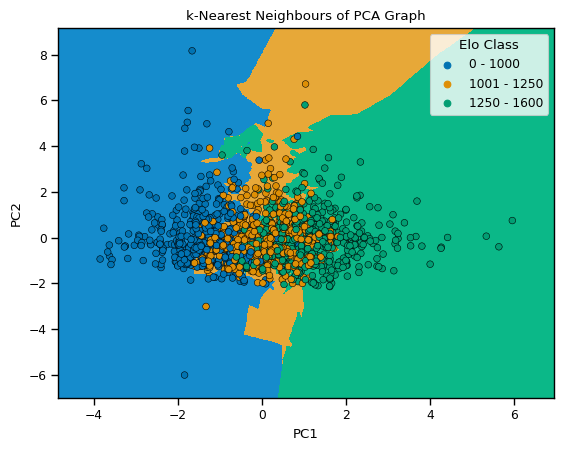

In [211]:
x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Z = np.array(Z, dtype=float)

plt.figure()

# Find colour vision deficiency (CVD) accessible colours
cmap_1 = ListedColormap(sns.color_palette("colorblind"))
print(sns.color_palette("colorblind").as_hex())

hex_cols = sns.color_palette("colorblind").as_hex()

cols = ["#158ccc", "#e7a838", "#0bb888"]
cmap_2 = ListedColormap(cols)

# Plot contours using CVD accessible colours
plt.contourf(xx, yy, Z, cmap=cmap_2)

# Labels for classes
train_lbl = train_lbl.replace({
    1: "0 - 1000",
    2: "1001 - 1250",
    3: "1250 - 1600"
})

# Plot data
ax2 = sns.scatterplot(x=X_data[:, 0], y=X_data[:, 1], hue=train_lbl,
palette="colorblind", alpha=1.0, edgecolor="black", hue_order=['0 - 1000', '1001 - 1250', '1250 - 1600'])
sns.move_legend(ax2, title='Elo Class', loc='best')

# Set graph dimensions
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(yy.min(), yy.max())

# Label axes
ax2.set_title("k-Nearest Neighbours of PCA Graph")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

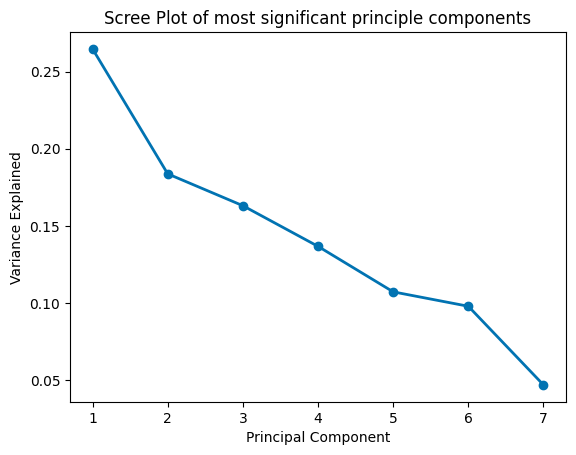

In [68]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color=hex_cols[0])
plt.title('Scree Plot of most significant principle components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


#LILA
# Documentation for confusion matrix:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# Link for interpreting confusion matrix output: https://stats.stackexchange.com/questions/318780/how-to-understand-confusion-matrix-for-3x3

# Actual is the y-axis on confusion matrix for 1, 2, 3 going downwards
confusion = confusion_matrix(test_predictions, test_lbl)
print('Confusion matrix:\n    Predicted\n    1   2   3')
print(confusion_matrix(test_predictions, test_lbl))
print('Precision score: ', precision_score(test_predictions, test_lbl, average='weighted')) # LILA CHECK THIS IS MEANT TO BE WEIGHTED AND NOT ONE OF THE OTHER CRITERIA
print('Recall score: ', recall_score(test_predictions, test_lbl, average='weighted'))
print('F1 score: ', f1_score(test_predictions, test_lbl, average='weighted'))
print('Accuracy: ', accuracy_score(test_predictions, test_lbl))

def sensitivity(TP, FN):
    '''Returns sensitivity of a class given the number of its true positives TP and false negatives FN.'''
    return TP / (TP + FN)

def selectivity(TN, FP):
    '''Returns selectivity of a class given the number of its true negatives TN and false positives FP.'''
    return TN / (TN + FP)

# Good explanation of what each TP, TN etc is: https://stackoverflow.com/questions/55635406/how-to-calculate-multiclass-overall-accuracy-sensitivity-and-specificity

# Class 1
TP_1 = confusion[0][0]
TN_1 = confusion[1][1] + confusion[1][2] + confusion[2][1] + confusion[2][2]
FP_1 = confusion[0][1] + confusion[0][2]
FN_1 = confusion[1][0] + confusion[2][0]

# Class 2
TP_2 = confusion[1][1]
TN_2 = confusion[0][0] + confusion[0][2] + confusion[2][0] + confusion[2][2]
FP_2 = confusion[1][0] + confusion[1][2]
FN_2 = confusion[0][1] + confusion[2][1]

# Class 3
TP_3 = confusion[2][2]
TN_3 = confusion[0][0] + confusion[0][1] + confusion[1][0] + confusion[1][1]
FP_3 = confusion[2][0] + confusion[2][1]
FN_3 = confusion[0][2] + confusion[1][2]


print('Sensitivity of 1: ', sensitivity(TP_1, FN_1))
print('Sensitivity of 2: ', sensitivity(TP_2, FN_2))
print('Sensitivity of 3: ', sensitivity(TP_3, FN_3))




Confusion matrix:
    Predicted
    1   2   3
[[227 163 134]
 [  0   0   0]
 [107 166 205]]
Precision score:  0.643899983757072
Recall score:  0.4311377245508982
F1 score:  0.5161134393685204
Accuracy:  0.4311377245508982
Sensitivity of 1:  0.6796407185628742
Sensitivity of 2:  0.0
Sensitivity of 3:  0.6047197640117994


c:\Users\s2202694\Downloads\python portable\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
# AUC info: https://stephenallwright.com/interpret-auc-score/

# AUC for logistic regression info: https://www.statology.org/auc-in-python/#:~:text=We%20can%20use%20the%20metrics.roc_auc_score%20%28%29%20function%20to,%3D%20metrics.roc_auc_score%28y_test%2C%20y_pred_proba%29%20%23print%20AUC%20score%20print%28auc%29%200.5602104030579559

# ROC for k-NN: https://www.cambridge.org/core/services/aop-cambridge-core/content/view/S1481803500013336

### Making Scree plot for K-Means, Elbow Method

Plotting mean squared error E against number of clusters K

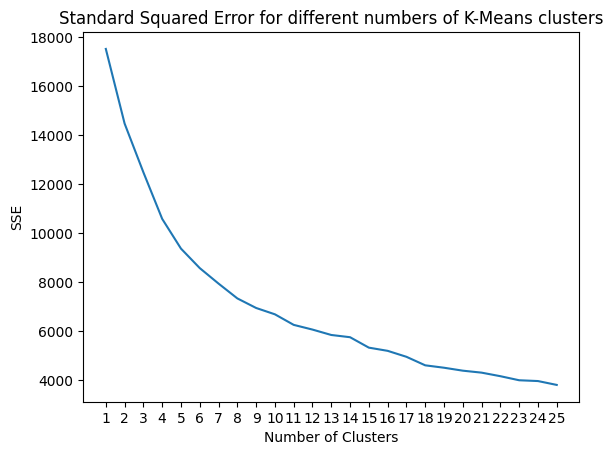

In [71]:
upper = 26

elo_labels = temptation_data["elo_class"]
elo_features = temptation_data.drop(columns=["elo_class"])

# Standardize ELO features
scaler = StandardScaler()
scaled_elo_feats = scaler.fit_transform(elo_features)

# Find standard squared error for each k
SSE = []
for k in range(1, upper):
    pre_k_means = KMeans(n_clusters=k, n_init=3)
    pre_k_means.fit(scaled_elo_feats)
    # Record SSE for this k
    SSE.append(pre_k_means.inertia_)

# Create Scree plot
plt.title("Standard Squared Error for different numbers of K-Means clusters")
plt.plot(range(1, upper), SSE)
plt.xticks(range(1, upper))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Applying K-Means

c:\Users\s2202694\Downloads\python portable\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'K-Means groupings for 9 clusters')

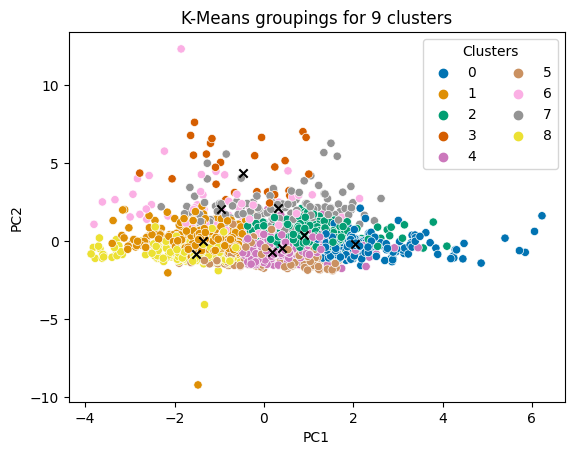

In [72]:
# Set number of clusters and PCAs
num_clusters = 9
num_PCA_components = 7

# Apply PCA to reduce number of dimensions
pca = PCA(n_components=num_PCA_components).fit(scaled_elo_feats)
pca_scores = pca.transform(scaled_elo_feats)

# Apply K-Means clustering
model_kmeans = KMeans(n_clusters=num_clusters, max_iter=10) # Lila Justify why max_iter=5
pca_scores_kmeans = model_kmeans.fit(pca_scores)

# Find cluster centres
centres = np.array(model_kmeans.cluster_centers_)

# Initialise new dataframe for K-Means predictions
kmeans_df = pd.DataFrame(pca_scores)
predicted = []

# Fit model to each PCA score
for s in pca_scores:
    predicted.append(model_kmeans.predict(s.reshape(1, -1)))

# Helper method to convert 'predicts's list format into a single element
def list_to_elem(lst):
    '''Converts single element list to an element'''
    return lst[0]

# Add predicted points to dataframe
kmeans_df['Cluster'] = predicted
kmeans_df['Cluster'] = kmeans_df['Cluster'].apply(list_to_elem)

# Plot scatter plot
sns.color_palette("colorblind")
sns.scatterplot(x=kmeans_df.iloc[:,0], y=kmeans_df.iloc[:,1], hue=kmeans_df['Cluster'], palette='colorblind')
plt.scatter(centres[:,0], centres[:,1], marker="x", color='black') # Plot centres of clusters

# Lila check these should be labelled PC1 and PC2
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc="upper right",ncol=2, title="Clusters")
plt.title(f"K-Means groupings for {num_clusters} clusters") # Lila better title?


### Evaluation techniques for K-NN

(Probs gonna not include K-Means???)

- Classification accuracy (DONE). Watch out for: should we also justify using a graph whhy 3 different ELO classes at these class boundaries gives the best accuracy? https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234
- Confusion matrix (DONE)
- F1 scores (DONE)
- Area Under Curve USE THIS ONE DEFINITELY
- Mean absolute error
- Mean Square Error



### Q1 evaluation idea
- Bayes factor? https://www.statisticshowto.com/bayes-factor-definition/
- AUC https://www.statology.org/auc-in-python/#:~:text=We%20can%20use%20the%20metrics.roc_auc_score%20%28%29%20function%20to,%3D%20metrics.roc_auc_score%28y_test%2C%20y_pred_proba%29%20%23print%20AUC%20score%20print%28auc%29%200.5602104030579559
